In [1]:
import copy
import time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

import utility as util

In [2]:
args = util.AttrDict(epochs=20, print_every=100, batch_size=32,
        learning_rate=0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Using device: cuda:0


In [3]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Training set: {len(trainset)} samples, {len(trainloader)} batches")
print(f"Test set has {len(testset)} samples, {len(testloader)} batches")

Files already downloaded and verified
Files already downloaded and verified
Training set: 50000 samples, 1563 batches
Test set has 10000 samples, 313 batches


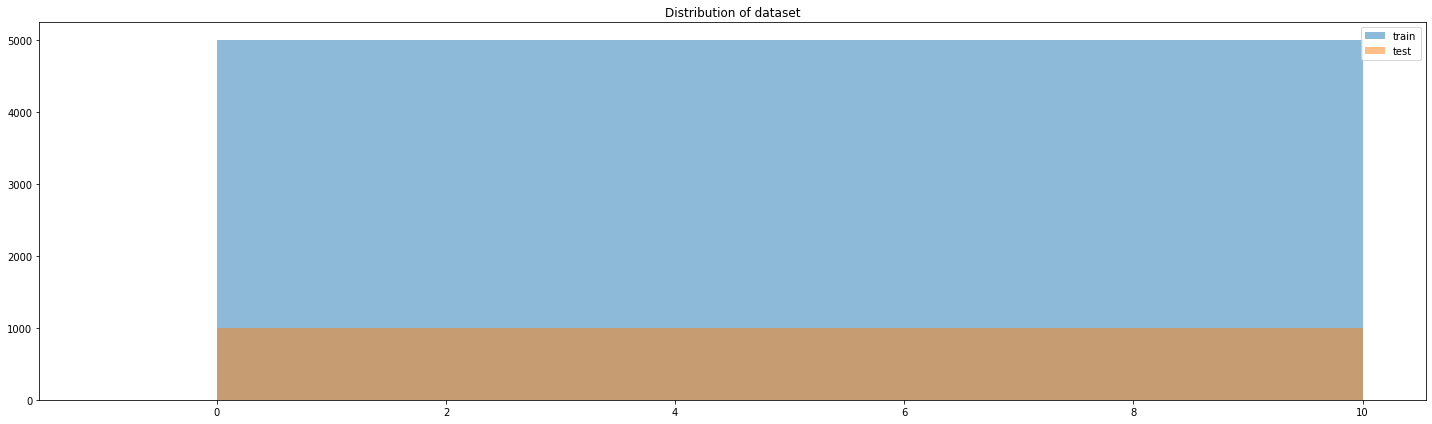

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))
axes = [ax]

labels = trainset.targets
bins = range(-1,11)
axes[0].hist(labels, bins=bins, alpha=0.5, label='train')
labels = testset.targets
axes[0].hist(labels, bins=bins, alpha=0.5, label='test')
axes[0].set_title("Distribution of dataset")
axes[0].legend(loc='upper right')
fig.tight_layout()

 deer  deer   car  ship  ship plane horse  ship  bird truck horse horse horse   car   car   cat horse  deer   dog   dog   dog  frog  bird  deer  deer   car  bird truck   dog truck truck truck


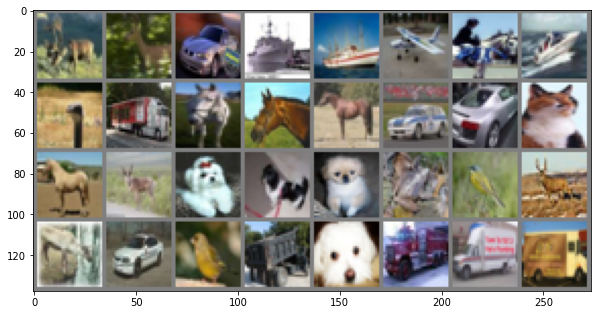

In [5]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

plt.figure(figsize=(10, 10))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))

In [8]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_size      = config.patch_size
        self.image_channels  = config.image_channels
        self.hidden_channels = config.hidden_channels
        self.output_size     = config.output_size
        self.filters         = config.filters
        try:
            self.strides  = config.strides
        except:
            self.strides  = [1 for _ in self.filters]
        try:
            self.paddings = config.paddings
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings = config.poolings
        except:
            self.poolings = [None for _ in self.filters]
        self.fc_features  = config.fc_features
        self.use_dropout  = 'use_dropout' not in config or config['use_dropout']
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        for idx, ((_in_channel, _out_channel), _filter, _stride, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.strides, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, stride=_stride, padding=_padding)
            conv_layers.append(conv)
            conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        conv_layers.append(nn.Flatten())
        self.convs = nn.Sequential(*conv_layers)
        dummy = self.convs(dummy)
        self.fc_inputs = dummy.numel()
        _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
        fc_layers = []
        for idx, (_in_features, _out_features) in enumerate(_features):
            fc = nn.Linear(_in_features, _out_features)
            fc_layers.append(fc)
            fc_layers.append(nn.ReLU())
        self.fcs = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.convs(x)
        x = self.fcs(x)
        return x

In [28]:
# Print Summary of Model

# Base model from
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# Parameters: 206,006, (Loss: 1.0720, Accuracy: 59.32% at 5 eps, 32 bs, 0.01 lr)
base_config = util.AttrDict(
    image_channels=3,
    patch_size=[32, 32],
    hidden_channels=[6, 16],
    filters=[5, 5],
    poolings=['max', None],
    fc_features= [120, 84],
    output_size=10)

config = util.AttrDict(**base_config)

# conv-5, maxpool, 2x conv-3, maxpool
# Parameters: 77,062, (Loss: 1.4970, Accuracy: 60.02% at 5 eps, 32 bs, 0.01 lr)
def modify_1():
    config.hidden_channels = [6, 12, 24]
    config.filters = [5, 3, 3]
    config.poolings = ['max', None, 'max']
    config.fc_features = [120]
# modify_1()

# 2x conv-5, maxpool, 2x conv-3, maxpool
# Parameters: 160,630; (Loss: 0.7962; Accuracy: 67.44% at 5 eps, 32 bs, 0.01 lr)
# (Loss: 0.4198; Accuracy: 70.60% at 10 eps, 32 bs, 0.01 -> 0.001 -> 0.0001 lr)
def modify_2():
    config.hidden_channels = [6, 12, 24, 48]
    config.filters = [5, 5, 3, 3]
    config.paddings = [1, 1, 0, 0]
    config.poolings = [None, 'max', None, 'max']
    config.fc_features = [120]
# modify_2()

# Increasing the FC doesn't improve much. Seems to result in needless incr. of parameters
# Parameters: 797,010; (Loss: 0.3222; Accuracy: 71.40% at 10 eps, 32 bs, 0.01 -> 0.001 -> 0.0001 lr)
def modify_3():
    config.hidden_channels = [6, 12, 24, 48]
    config.filters = [5, 5, 3, 3]
    config.paddings = [1, 1, 0, 0]
    config.poolings = [None, 'max', None, 'max']
    config.fc_features = [600, 100]
# modify_3()

# Parameters: 538,698; (Loss 0.3870; Accuracy 74.01% at 5 eps, 32 bs, 0.01 lr)
# Saturates with 75% accuracy
def modify_4():
    config.hidden_channels = [32, 64, 128, 128]
    config.filters = [5, 5, 3, 3]
    config.paddings = [2, 2, 1, 1]
    config.poolings = ['max', 'max', None, 'max']
    config.fc_features = [128]
# modify_4()

# adding more than 2x conv3x3 isn't worth it
# Parameters: 686,282 (loss 0.7749; accuracy: 71.93% at 5 eps, 32 bs, 0.01 lr with exponential LR at 0.95)
def modify_5():
    config.hidden_channels = [32, 64, 128, 128, 128]
    config.filters = [5, 5, 3, 3, 3]
    config.paddings = [2, 2, 1, 1, 1]
    config.poolings = ['max', 'max', None, None, 'max']
    config.fc_features = [128]
modify_5()

# adding many hidden channels
# Parameters: 2,010,058; (Loss 0.6532; Accuracy: 76.83% at 5 eps, 32 bs, 0.01 lr)
def modify_6():
    config.hidden_channels = [128, 256, 512]
    config.filters = [5, 3, 3]
    config.paddings = [2, 1, 1]
    config.poolings = ['max', 'max', 'max']
    config.fc_features = [64]
# modify_6()

# dulicating the number of hidden channels
# Saturates with 78% accuracy
def modify_7():
    config.hidden_channels = [64, 128, 256, 256]
    config.filters = [5, 5, 3, 3]
    config.paddings = [2, 2, 1, 1]
    config.poolings = ['max', 'max', None, 'max']
    config.fc_features = [128]
# modify_7()

net = Net(config)
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(net, input_size=(1, 3, 32, 32), col_names=col_names, col_width=18)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
Net                                      --                 --                 --                 --
├─Sequential: 1-1                        [1, 3, 32, 32]     [1, 2048]          --                 --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]     [1, 32, 32, 32]    2,432              [3, 32, 5, 5]
│    └─ReLU: 2-2                         [1, 32, 32, 32]    [1, 32, 32, 32]    --                 --
│    └─MaxPool2d: 2-3                    [1, 32, 32, 32]    [1, 32, 16, 16]    --                 --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]    [1, 64, 16, 16]    51,264             [32, 64, 5, 5]
│    └─ReLU: 2-5                         [1, 64, 16, 16]    [1, 64, 16, 16]    --                 --
│    └─MaxPool2d: 2-6                    [1, 64, 16, 16]    [1, 64, 8, 8]      --                 --
│    └─Conv2d: 2-7                       [1, 64, 8, 8]    


Test accuracy: 43.56%



Test accuracy: 59.71%



Test accuracy: 67.20%



Test accuracy: 71.39%



Test accuracy: 74.40%



Test accuracy: 76.50%



Test accuracy: 75.62%



Test accuracy: 76.61%



Test accuracy: 76.10%



Test accuracy: 76.00%



Test accuracy: 76.64%



Test accuracy: 74.76%



Test accuracy: 75.80%



Test accuracy: 76.54%



Test accuracy: 76.76%



Test accuracy: 76.65%



Test accuracy: 75.68%



Test accuracy: 76.73%



Test accuracy: 75.40%



Test accuracy: 76.80%
Done.
Training time took 256.3293499946594 seconds


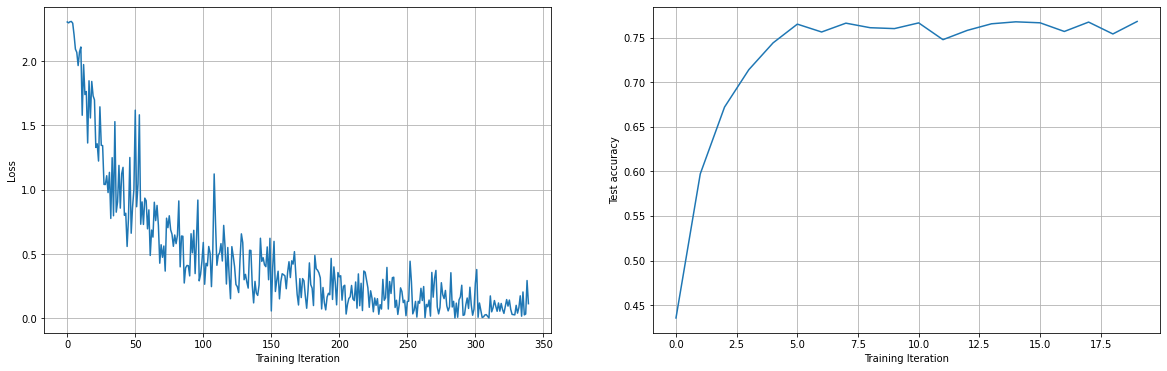

In [29]:
loss_over_time = []
acc_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.97)
#     scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Test accuracy: {:1.2%}".format(correct / total))
        acc_over_time.append(correct / total)
        if scheduler:
            scheduler.step()
    print("Done.")

net = Net(config).to(device)
should_create_new_instance = True
if should_create_new_instance:
    start = time.time()
    train(net, args, trainloader, testloader)
    end = time.time()
    print(f"Training time took {end - start} seconds")
    torch.save(net.state_dict(), './models/2nd.cifar_net.pth')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.ravel()
    axes[0].plot(range(len(loss_over_time)), loss_over_time)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Training Iteration")
    axes[0].grid()
    axes[1].plot(range(len(acc_over_time)), acc_over_time)
    axes[1].set_ylabel("Test accuracy")
    axes[1].set_xlabel("Training Iteration")
    axes[1].grid()
    
else:
    net.load_state_dict(torch.load('./models/2nd.cifar_net.pth'))

In [ ]:
### test_sample = testset[14]
test_image = test_sample[0]

plt.figure(figsize=(2,2))
imshow(test_image)

# demonstrating how to get label from image.
with torch.no_grad():
    net.eval()
    output = net(test_image.unsqueeze(0).cuda())
a = torch.argmax(output).cpu().numpy().tolist()
plt.gca().set_title(trainset.classes[a])

# it's possible to index and get the length of nn.Sequential modules.
0, 1, 3, 4
_h = net.convs[0](test_image.unsqueeze(0).cuda())
# inter_1 has shape (1, 32, 32, 32)
_inter_1 = net.convs[1](_h)
inter_1 = _inter_1.squeeze(0)
print(inter_1.shape)

_h = net.convs[2](_inter_1)
_h = net.convs[3](_h)
# inter_2 has shape (1, 64, 16, 16)
_inter_2 = net.convs[4](_h)
inter_2 = _inter_2.squeeze(0)

print(inter_2.shape)

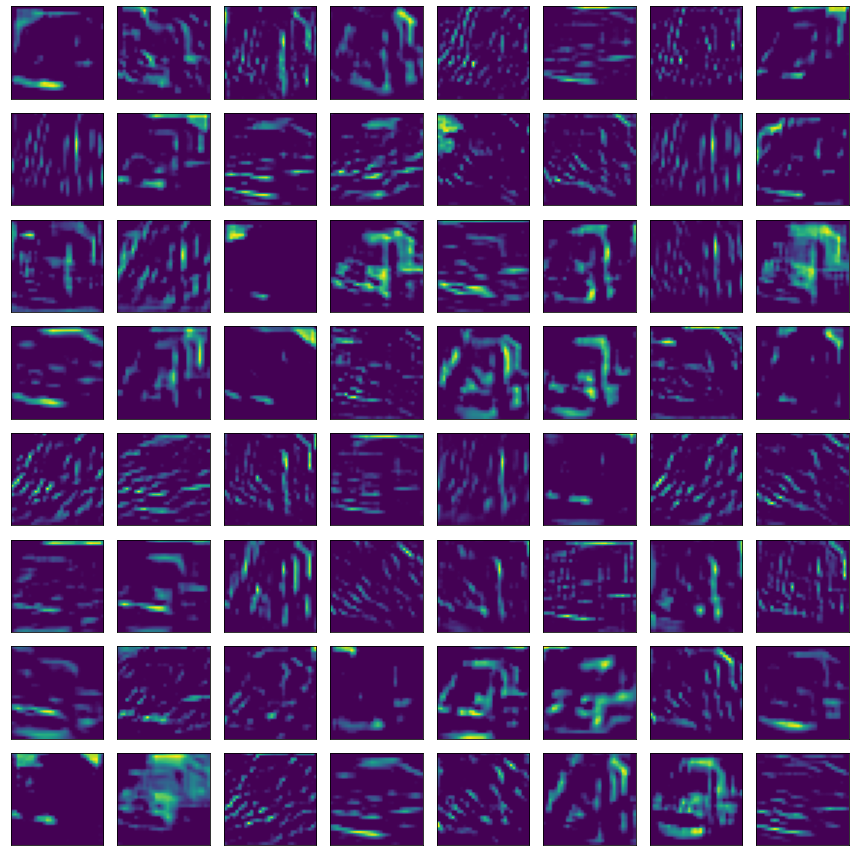

In [27]:
_inter_1 = inter_1.cpu().detach().numpy()

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.ravel()

for i, h in enumerate(_inter_1):
    axes[i].imshow(h)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

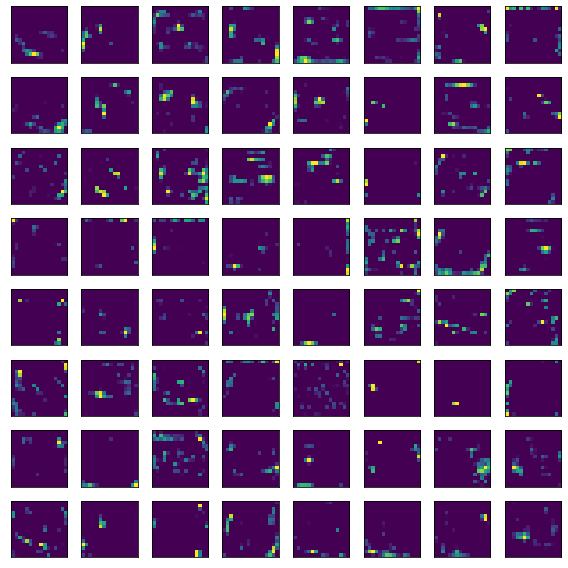

In [20]:
_inter_2 = inter_2.cpu().detach().numpy()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.ravel()

for i, h in enumerate(_inter_2):
    axes[i].imshow(h)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

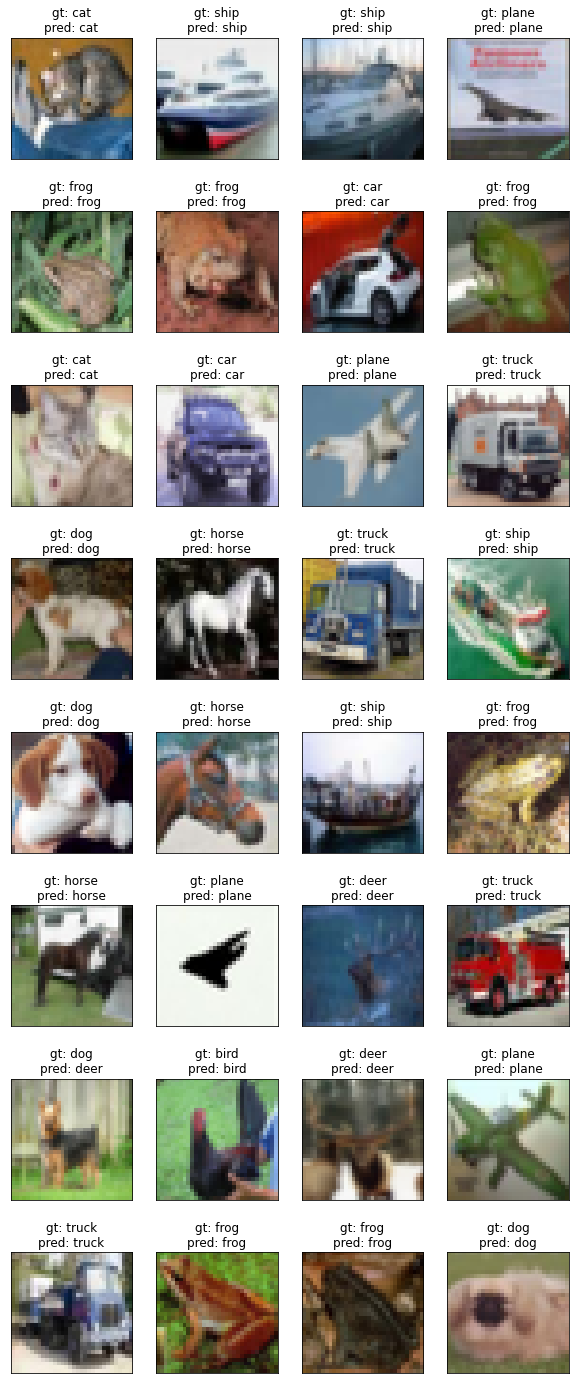

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
outputs = net(_images)
_, predicted = torch.max(outputs, 1)

# print images
# imshow(torchvision.utils.make_grid(images))
# get labels
ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 79 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    net.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    net.train()


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))


Accuracy for class plane is: 82.6 %
Accuracy for class car   is: 87.7 %
Accuracy for class bird  is: 71.4 %
Accuracy for class cat   is: 62.9 %
Accuracy for class deer  is: 79.5 %
Accuracy for class dog   is: 71.2 %
Accuracy for class frog  is: 86.4 %
Accuracy for class horse is: 83.9 %
Accuracy for class ship  is: 87.4 %
Accuracy for class truck is: 86.9 %
